# Sprint20課題 セグメンテーション

医療データに対するセグメンテーションを行います。KaggleのTGS Salt Identification Challengeのデータセットを使用します。

[TGS Salt Identification Challenge | Kaggle](https://www.kaggle.com/c/tgs-salt-identification-challenge)

セグメンテーション手法としてU-Net[1]を使います。

[1]O.Ronneberger, P.Fischer, T.Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234–241, 2015

https://arxiv.org/pdf/1505.04597.pdf

## 【問題1】学習・推定
以下のKeras実装を使用して学習・推定を行ってください。

[zhixuhao/unet: unet for image segmentation](https://github.com/zhixuhao/unet)

**GPU環境での学習**

大規模なデータセット、大きなモデルになるため、GPUを使用する必要があります。

**新たなデータセットの適用**

Sprint18,19と同様に実装で用意されたものとは異なるデータセットを入力します。

In [1]:
# モジュール配置されているパスを取得
import sys
sys.path.append("unet")

In [12]:
# モジュールインポート
from model import *
from data import *

import os
import skimage
from skimage.color import rgb2gray
from PIL import Image
import matplotlib.pyplot as plt


### 学習(AWS EC2 p2.xlargeインスタンス)

In [9]:
# 学習情報の設定
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(2,'./train','images','masks',data_gen_args,save_to_dir = None)

#　U-Netでの学習
model = unet()
model_checkpoint = ModelCheckpoint('unet_solt.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=4000,epochs=5,callbacks=[model_checkpoint])

/home/ubuntu/work/unet/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Epoch 1/5
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
4000/4000 [==============================] - 1787s 447ms/step - loss: 0.4700 - acc: 0.7940

Epoch 00001: loss improved from inf to 0.46996, saving model to unet_solt.hdf5
Epoch 2/5
4000/4000 [==============================] - 1774s 444ms/step - loss: 0.3604 - acc: 0.8805

Epoch 00002: loss improved from 0.46996 to 0.36043, saving model to unet_solt.hdf5
Epoch 3/5
4000/4000 [==============================] - 1772s 443ms/step - loss: 0.3262 - acc: 0.8969

Epoch 00003: loss improved from 0.36043 to 0.32619, saving model to unet_solt.hdf5
Epoch 4/5
4000/4000 [==============================] - 1775s 444ms/step - loss: 0.2579 - acc: 0.9100

Epoch 00004: loss improved from 0.32619 to 0.25792, saving model to unet_solt.hdf5
Epoch 5/5
4000/4000 [==============================] - 1776s 444ms/step - loss: 0.2240 - acc: 0.9187

Epoch 00005: loss improved from 0.25792 to 0.22403, saving model to unet_solt.

### 推定(ローカル)

In [3]:
# 重みファイルの読み込み
model = load_model('unet_solt.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
# テスト情報の設定
testGene = testGenerator(
    test_path='./test/images',
    num_image = 30,
    target_size = (256,256,1),
    flag_multi_class = True,
    as_gray = False
)

# 推定
results = model.predict_generator(testGene,30,verbose=1)

#　推定結果を保存
saveResult("./test/predict",results)

30/30 [==============================] - 64s 2s/step


/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./test/predict/ccc645a996.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./test/predict/7efd271bba.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./test/predict/298bda8c6b.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./test/predict/37afd06dfa.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./test/pr

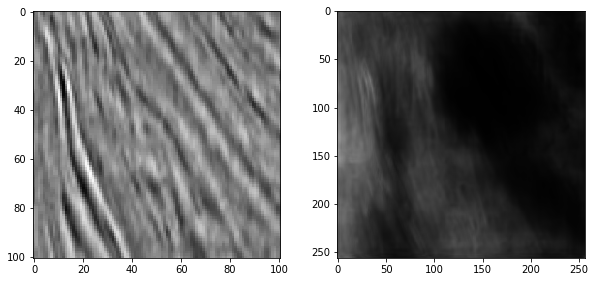

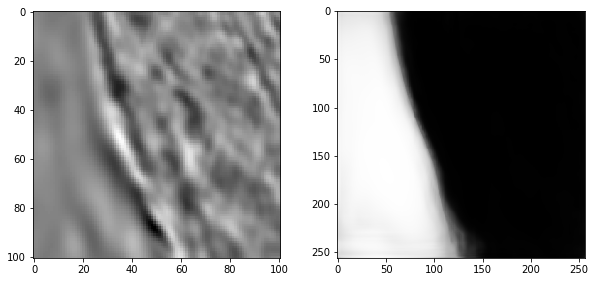

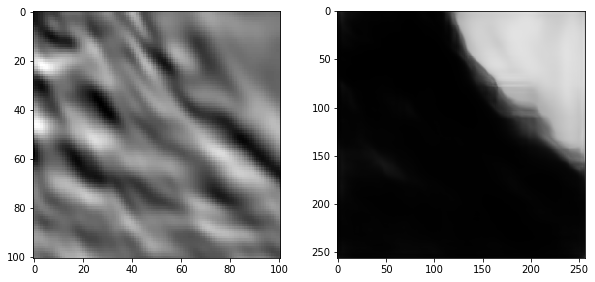

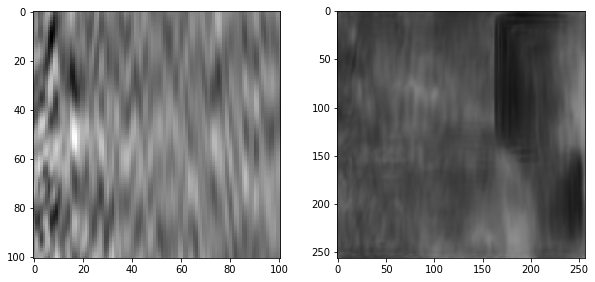

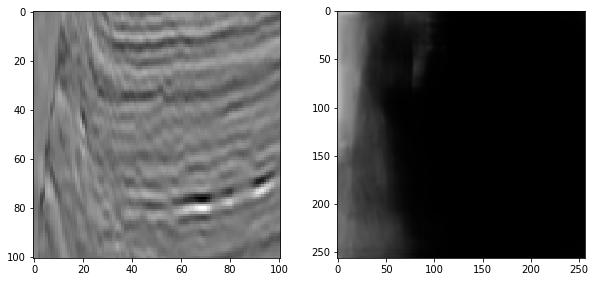

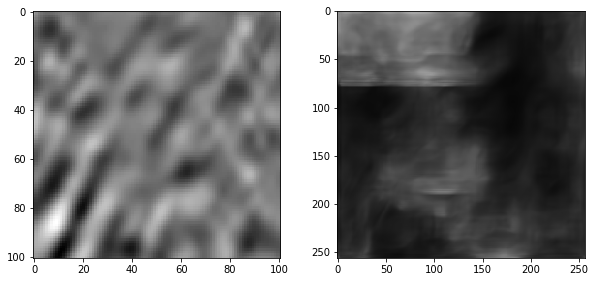

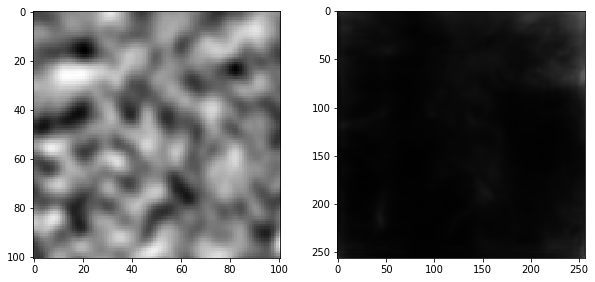

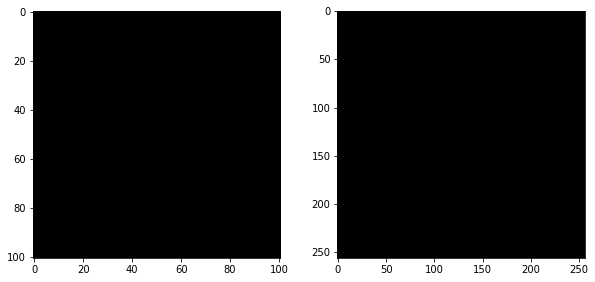

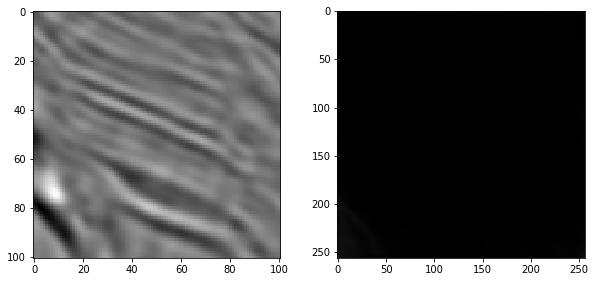

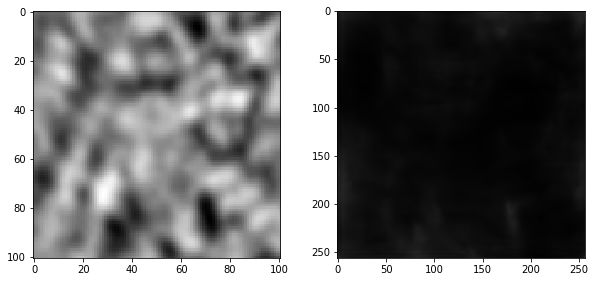

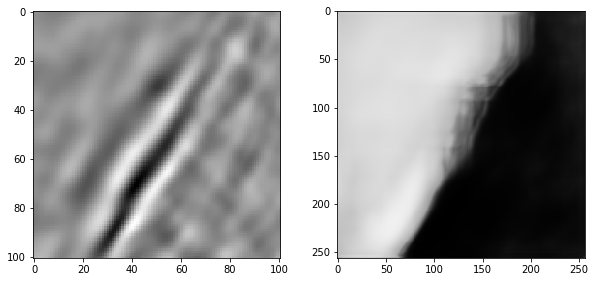

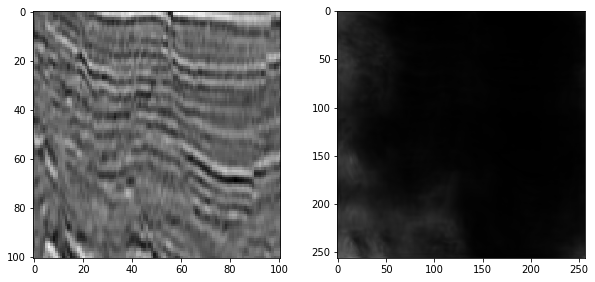

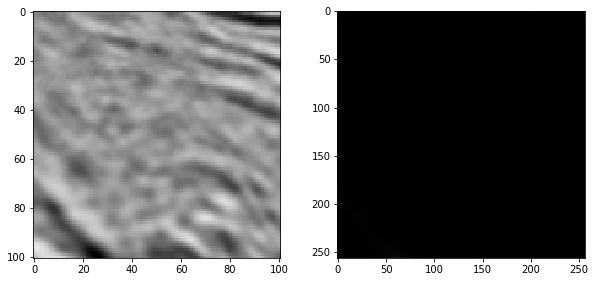

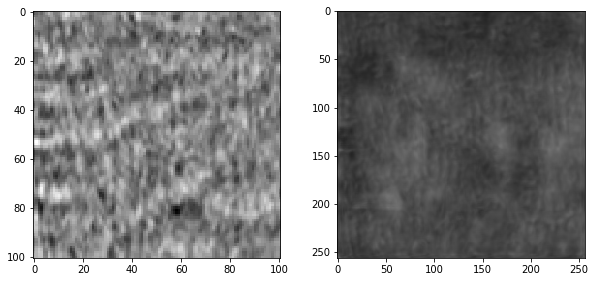

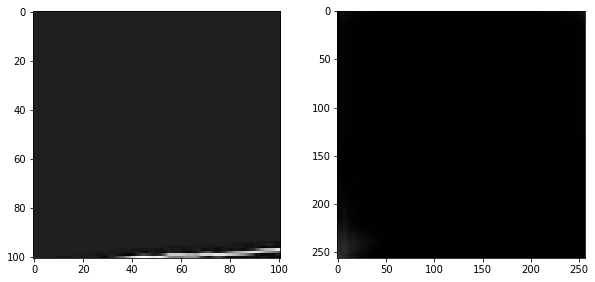

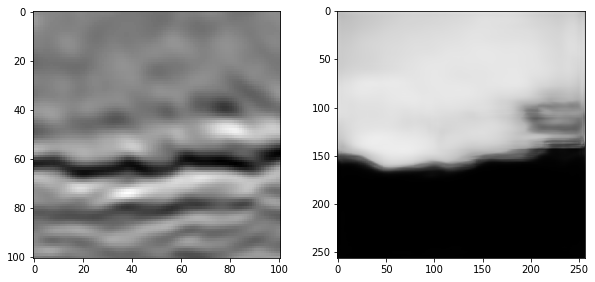

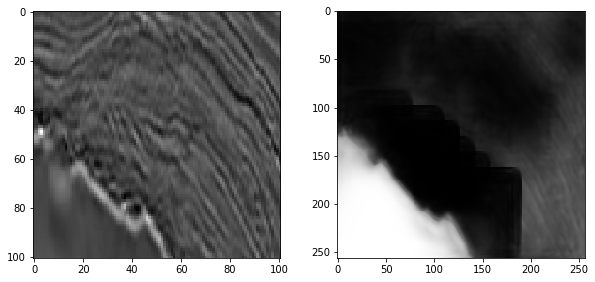

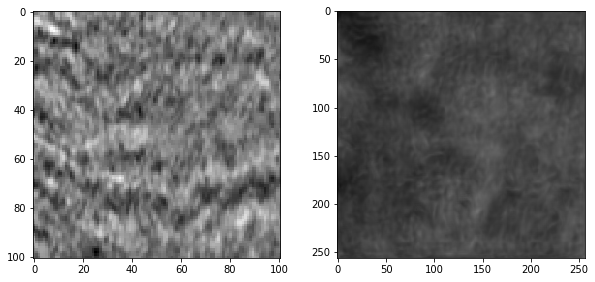

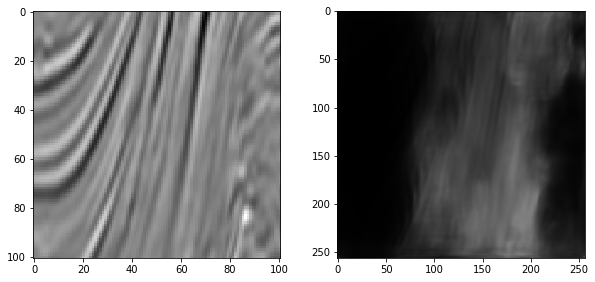

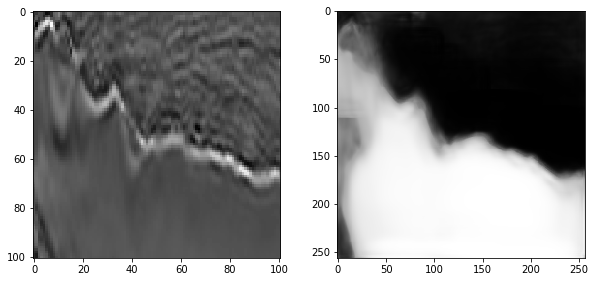

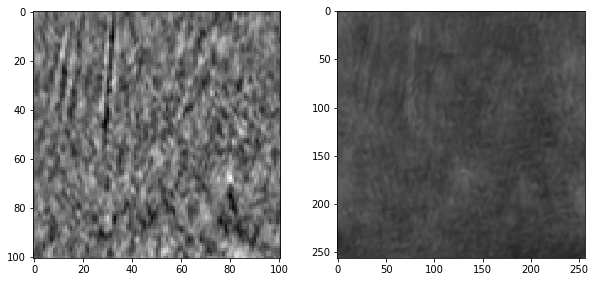

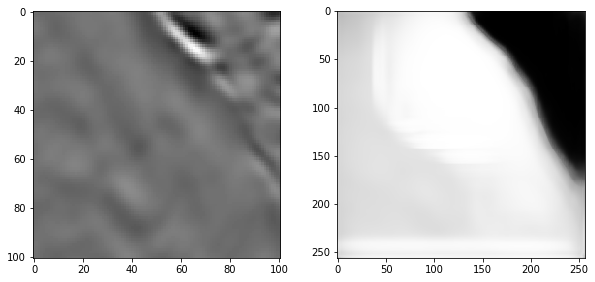

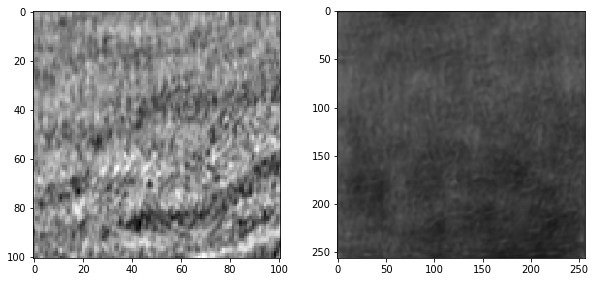

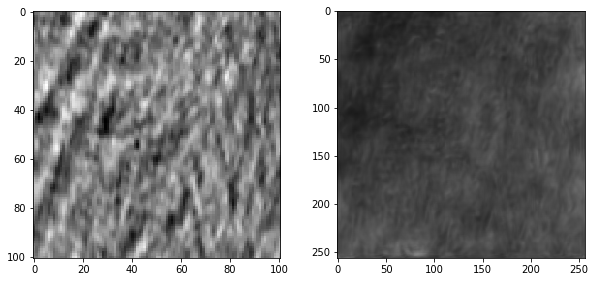

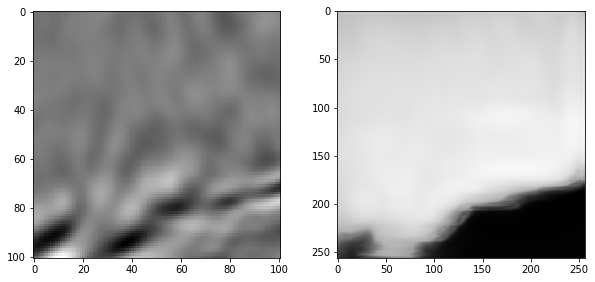

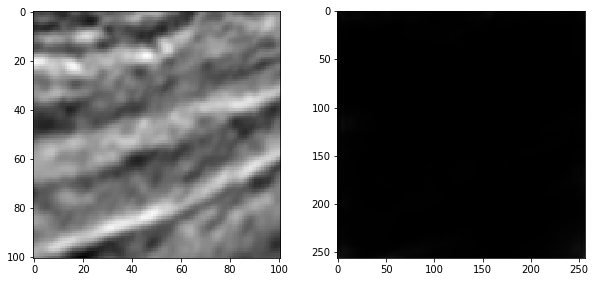

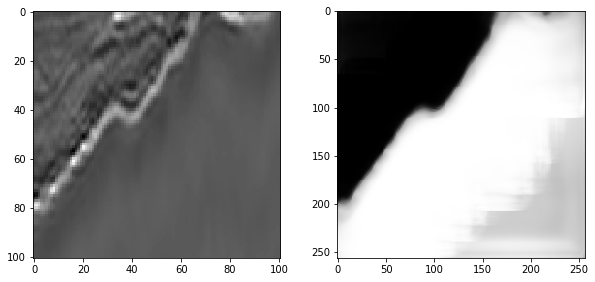

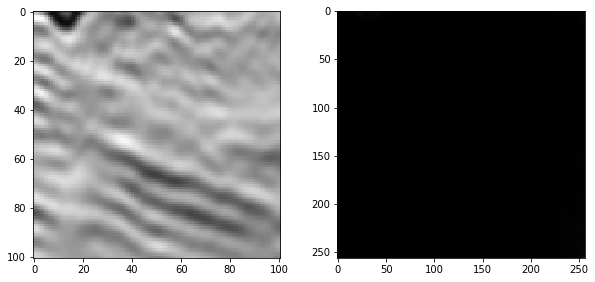

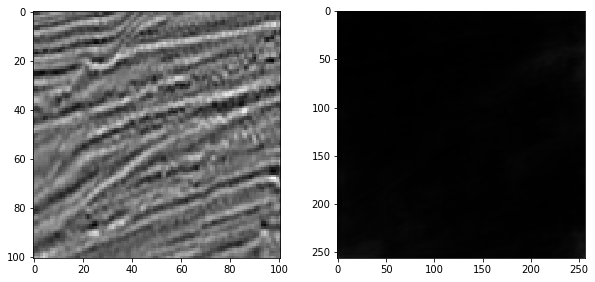

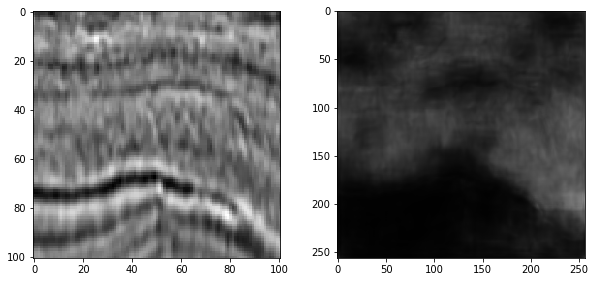

In [28]:
# 推定結果の表示
pred_path = './test/predict/'
for i, file in enumerate(os.listdir(pred_path)):
    test_img = Image.open('./test/images/' + file)
    pred_img = Image.open(pred_path + file)
    
    plt.figure(figsize=(10,10)) # figureの縦横の大きさ
    
    plt.subplot(2,2,1)
    plt.imshow(test_img)

    plt.subplot(2,2,2)
    plt.imshow(pred_img)
    

- AWS環境で学習時間は約150分
- 予測結果については、３０枚の画像をpredictし、一部の画像にて塩らしきものを検出

## 【問題2】コードリーディング
論文[1]に目を通した上で、上記実装のコードリーディングを行ってください。

![Unet](U-Net_Architecture.png)

### unet_model

下記コメントに記載

```python
def unet(pretrained_weights = None,input_size = (256,256,1)):
    
    # 一層目での畳込み(encoder)
    inputs = Input(input_size)
    # conv 3*3, Relu関数を２回
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    # 一層目から二層目への2*2maxpoling
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 二層目での畳込み(encoder)
    # conv 3*3, Relu関数を２回
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    # 二層目から三層目への2*2maxpooling
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 三層目での畳込み(encoder)
    # conv 3*3, Relu関数を２回
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    #三層目から四層目への2*2maxpooling
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 四層目での畳込み(encoder)
    # conv 3*3, Relu関数を２回
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    # 過学習を防ぐため、50%の入力ユニットをドロップする
    drop4 = Dropout(0.5)(conv4)
    
    # 四層目からU-Netモデル図における最下層への2*2maxpooling
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Unetにおける最下層
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    # 過学習を防ぐため、50%の入力ユニットをドロップする
    drop5 = Dropout(0.5)(conv5)

    # 最下層から四層目への逆畳み込み
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    # 四層目のencoderからの特徴マップを連結
    merge6 = concatenate([drop4,up6], axis = 3)

    # 四層目での畳込み(decoder)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    # 四層目から三層目への逆畳み込み
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    # 三層目のencoderからの特徴マップを連結
    merge7 = concatenate([conv3,up7], axis = 3)

    # 三層目での畳込み(decoder)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    # 三層目から二層目への逆畳み込み
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))

    # 二層目のencoderからの特徴マップを連結
    merge8 = concatenate([conv2,up8], axis = 3)

    # 二層目での畳込み(decoder)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    # 二層目から一層目への逆畳み込み
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))

    #一層目のencoderからの特徴マップを連結
    merge9 = concatenate([conv1,up9], axis = 3)

    # 一層目での畳込み(decoder)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    # 出力層
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    #訓練過程の設定
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    # 学習済みモデルがあれば、読み込む
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

```